In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk import bigrams, trigrams
from tqdm import tqdm
import notification_nltf as ntf
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
import nltk
from string import punctuation
from nltk.stem import PorterStemmer,WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyamrana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Loading the dataset
df = pd.read_parquet('final_dataset.parquet')
df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


# Creating the corpus and cleaning up the text

In [3]:
df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [24]:
# Function to remove punctuation and lower the word
def clean_text(sentence):
    # removing the URL links 
    sentence = re.sub(r'http\S+|www\S+', '', sentence)
    # removing unicode characters - emojis and other characters
    sentence = re.sub(r'[^\x00-\x7F]+', '', sentence)
    # Removing punctuation
    sentence = re.sub(rf'[{punctuation}]', '', sentence)
    # Lower casing and removing trailing white spaces
    return sentence.lower().strip()

# doing POS tagging
def get_wordnet_pos(word):
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to do lemmetization
# We intend to do lemmitization, as indicated by the functions above but it was taking a lot of time, so we are currently going towards stemming and would use this in the future
def lemmetizer(tokens, corpus, word_count, stop_words, lem):
    assert isinstance(word_count, defaultdict), "Not a defaultdict object"
    assert isinstance(tokens, list), "tokens should be a list"
    assert isinstance(corpus, set), "corpus should be a set"

    
    pos_tags = nltk.pos_tag(tokens)
    lemmetized_tk = []
    for word, tag in pos_tags:
        if word not in stop_words:
            lemmitized_word = lem.lemmatize(word, pos=get_wordnet_pos(tag))
            lemmetized_tk.append(lemmitized_word)
            #adding to corpus
            corpus.add(lemmitized_word)
            #adding to word_count
            word_count[lemmitized_word] += 1
    return lemmetized_tk, corpus, word_count

def stemming_words(tokens, corpus, word_count, stop_words):
    assert isinstance(word_count, defaultdict), "Not a defaultdict object"
    assert isinstance(tokens, list), "tokens should be a list"
    assert isinstance(corpus, set), "corpus should be a set"

    stem = PorterStemmer()
    stemmed_list = []
    for word in tokens:
        if word not in stop_words:
            stemmed = stem.stem(word)
            stemmed_list.append(stemmed)
            # adding to corpus
            corpus.add(stemmed)
            # adding to word count
            word_count[stemmed] += 1
    return stemmed_list, corpus, word_count

We intend to do lemmitization but it is very time consuming, would resort to stemming and would use this for the next milestone


In [26]:
corpus = set()
corpus_without_stopwords = set()
word_count = defaultdict(int)

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

articles_tokenized = []
lem = WordNetLemmatizer()

# For next mileston as indicated above
# Iterate through articles
# for _, row in tqdm(df.iterrows(), total=df.shape[0]):  
#     # Cleaning the sentence
#     cleaned_article = clean_text(row['article']).split()
#     tokens_cleaned, corpus, word_count = lemmetizer(cleaned_article, corpus, word_count, stop_words, lem)
#     articles_tokenized.append(tokens_cleaned)


for _, row in tqdm(df.iterrows(), total=df.shape[0]):  
    # Cleaning the sentence
    cleaned_article = clean_text(row['article']).split()
    tokens_cleaned, corpus, word_count = stemming_words(cleaned_article, corpus, word_count, stop_words)
    articles_tokenized.append(tokens_cleaned)

ntf.send_notification(message="Completed.", topic='vscode_tester')

100%|██████████| 298603/298603 [18:59<00:00, 261.93it/s]  

Notification sent to vscode_tester


In [45]:
# Adding tokenized sentence to the dataframe and saving it as parquet
df['tokenized'] = articles_tokenized
df.to_parquet('datum_with_tokens.parquet', compression='snappy')

## EDA

In [13]:
# exploring the number of words that we have 
print(f"The corpus size is {len(corpus)}")

The corpus size is 698450


Looking at N-grams : Bi-grams and Tri-grams

In [4]:
bigram_dict = defaultdict(int)
trigrams_dict = defaultdict(int)

for tokens in tqdm(df['tokenized']):
    # Creating bigrams
    grams = bigrams(tokens)
    for bg in grams:
        bigram_dict[bg] += 1

    # creating trigrams
    grams = trigrams(tokens)
    for tg in grams:
        trigrams_dict[tg] += 1

# sorting and getting top 10
top_10_bigram_dict = sorted(bigram_dict, key=bigram_dict.get, reverse=True)[:10]
top_10_trigram_dict = sorted(trigrams_dict, key=trigrams_dict.get, reverse=True)[:10]

100%|██████████| 298603/298603 [03:44<00:00, 1329.46it/s]


In [6]:
top_10_bigram_dict

[('per', 'cent'),
 ('last', 'year'),
 ('new', 'york'),
 ('scroll', 'video'),
 ('unit', 'state'),
 ('year', 'ago'),
 ('last', 'week'),
 ('2013', 'updat'),
 ('prime', 'minist'),
 ('told', 'cnn')]

In [8]:
top_10_trigram_dict

[('daili', 'mail', 'report'),
 ('presid', 'barack', 'obama'),
 ('new', 'york', 'citi'),
 ('mail', 'report', 'publish'),
 ('two', 'year', 'ago'),
 ('new', 'york', 'time'),
 ('loui', 'van', 'gaal'),
 ('express', 'commentari', 'sole'),
 ('opinion', 'express', 'commentari'),
 ('daili', 'mail', 'australia')]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


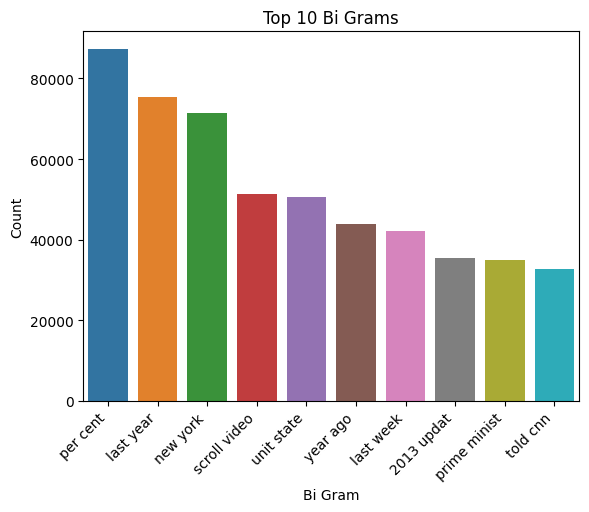

In [22]:
# Plotting the count for the top 10 Bigrams and tri grams
plt.title("Top 10 Bi Grams")
cats = top_10_bigram_dict
vals = [bigram_dict[x] for x in cats]
cats_strings = [" ".join(cat) for cat in cats]
sns.barplot(x = cats_strings, y = vals)
plt.xlabel("Bi Gram")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


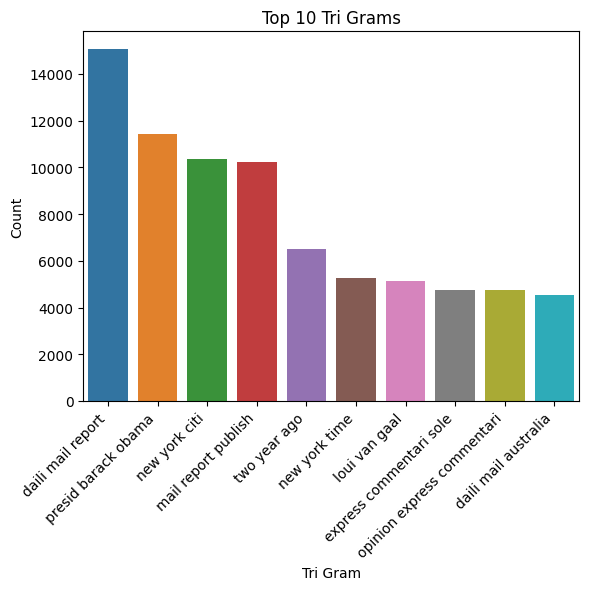

In [ ]:
# Plotting the count for the top 10 trigrams and tri grams
plt.title("Top 10 Tri Grams")
cats = top_10_trigram_dict
vals = [trigrams_dict[x] for x in cats]
cats_strings = [" ".join(cat) for cat in cats]
sns.barplot(x = cats_strings, y = vals)
plt.xlabel("Tri Gram")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

Wordcloud

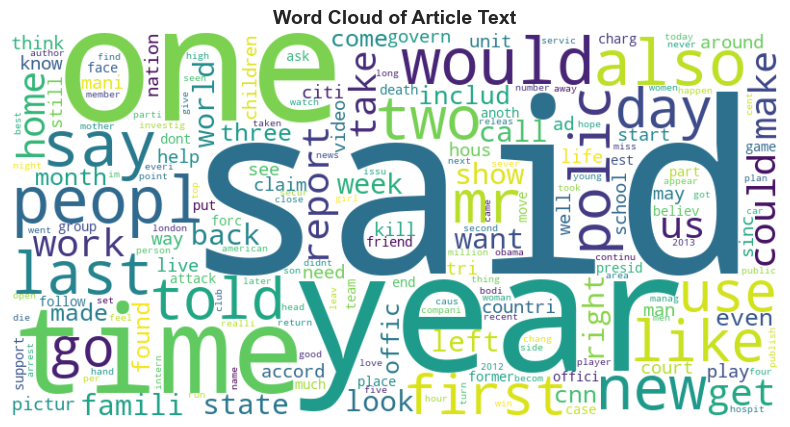

In [28]:
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(word_count)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Article Text", fontsize=14, fontweight="bold")
plt.show()

Article Length

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


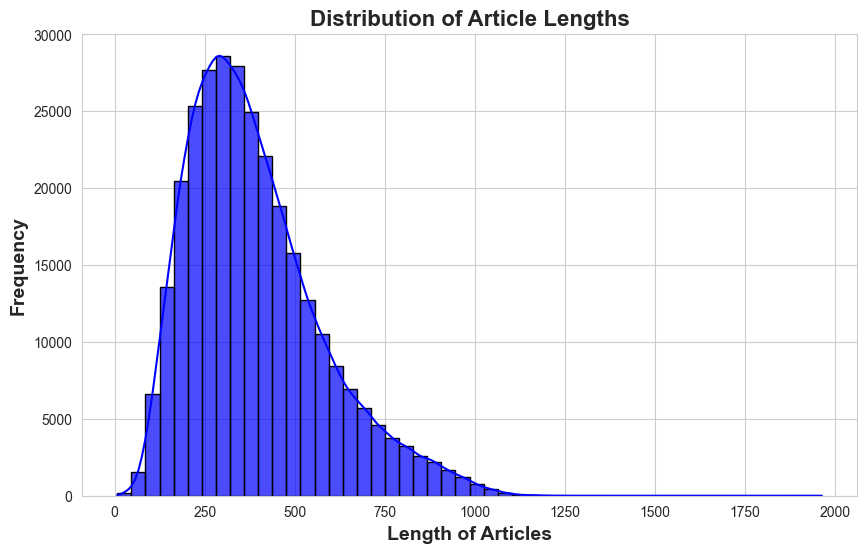

In [29]:
df['length_article'] = df['tokenized'].apply(len)
# Set a seaborn style
sns.set_style("whitegrid")

# Create a larger figure
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(df['length_article'], bins=50, kde=True, color='blue', edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Length of Articles", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Distribution of Article Lengths", fontsize=16, fontweight='bold')

# Show the plot
plt.show()

## Removing the common words using TFIDF and limiting corpus to 10K

We are using 10K as the corpus size to avoid extraneous features from entering the corpus of around 70K words. The TFIDF model would help us in the same and make the vectorization easier for us

In [34]:
def identity_tokenizer(tokens):
  return tokens

model = TfidfVectorizer(
    tokenizer=identity_tokenizer,
    preprocessor=lambda x: x, 
    lowercase=False, 
    max_features=10_000,
    token_pattern=None 
)

tfidf_matrix = model.fit_transform(df['tokenized'])

# Get feature names (words)
feature_names = model.get_feature_names_out()

# Create a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

